# Notebook to process pcfusage.sh script


In [205]:
import sys
import json
import datetime

import pandas as pd

# Don't know how to use it yet
import ipywidgets as widgets
from IPython.display import display

# TODO - capture via script
# Environment metadata

# BORGESCLOUD File
# file = "/Users/mborges/Tools/PCF/scripts/dev_foundation.json"
# capture_date = datetime.datetime(2018, 6, 26, 0, 0)
# diego_cell = {"number_of": 4, "vcpu": 4, "ram_gb": 32, "disk_gb": 32 }

# Anadarko
file = "/Users/mborges/Tools/PCF/scripts/samples/anadarko_foundation.json"
capture_date = datetime.datetime(2018, 7, 2, 22, 0)
diego_cell = {"number_of": 8, "vcpu": 8, "ram_gb": 32, "disk_gb": 256 }

# Know system orgs
system_orgs = ["system", "p-dataflow", "p-spring-cloud-services"]

total_vcpu = diego_cell['number_of'] * diego_cell['vcpu']
total_memory = diego_cell['number_of'] * diego_cell['ram_gb']

# Foundation json capture via script
with open(file, "r") as read_file:
    data = json.load(read_file)
    
df_apps = pd.DataFrame(data[0]["apps"])
df_orgs = pd.DataFrame(data[1]["orgs"])
df_service_instances = pd.DataFrame(data[2]["service_instances"])
df_services = pd.DataFrame(data[3]["services"])
df_spaces = pd.DataFrame(data[4]["spaces"])
df_users = pd.DataFrame(data[5]["users"])

# Fix column names so we can merge
df_orgs = df_orgs.rename(columns = {"name":"org"})
df_spaces = df_spaces.rename(columns = {"name": "space", "org":"org_guid"})
df_apps = df_apps.rename(columns = {"space": "space_guid"})

# Merge spaces and orgs and create an non_system_spaces series
environments = pd.merge(df_spaces, df_orgs, on="org_guid")
non_system_spaces = (environments['org'].isin(system_orgs))

# Merge apps with spaces to get org and space names
apps = pd.merge(df_apps, environments, on="space_guid")

# Merge services with service instances
services = pd.merge(df_services, df_service_instances, on="service_guid")

# Non system applications
#non_system_apps = (apps['org'] != 'system') & (apps['org'] != 'p-dataflow')
system_apps = apps['org'].isin(system_orgs)
non_system_apps = ~apps['org'].isin(system_orgs)

df_non_system_apps = apps[non_system_apps]


# Foundation by Numbers
## speed
Organizations can represent different business units, spaces environments where initial setup lead and process time are usually high. Services and buildpacks represents the middleware required to develop applications.

In [6]:
print ("Orgs: {}".format(len(df_non_system_apps['org'].unique())))
print ("Spaces: {}".format(len(df_non_system_apps['space'].unique())))
print ("Users: {}".format(len(list(df_users))))
print ("Services: {}".format(len(df_services['label'].unique())))
print ("Unique Applications: {}".format(len(df_non_system_apps['name'].unique())))
print ("Buildpacks: {}".format(len(df_non_system_apps['buildpack'].unique())))
print ("Containers: {}".format(df_non_system_apps['instances'].sum()))
print ("Service Instances: {}".format(len(df_services_instances['name'].unique())))



Orgs: 4
Spaces: 5
Users: 62
Services: 17
Unique Applications: 79
Buildpacks: 6
Containers: 119
Service Instances: 35


# Application Instance Memory in MB
## scalability
Statistics on memory usage by all customer applications. This can show scalability of PCF by comparing min and max memory sizes. 

In [188]:
df_non_system_apps['memory'].describe()


count       93.000000
mean      1156.860215
std       1424.443000
min         64.000000
25%       1024.000000
50%       1024.000000
75%       1024.000000
max      12228.000000
Name: memory, dtype: float64

# Density
## savings
Number of containers per CPU and per vCPU. This can show infrastructure consolidation and savings

In [8]:
containers_per_cell = apps[non_system_apps]['instances'].sum() / diego_cell['number_of']
containers_per_vcpu = apps[non_system_apps]['instances'].sum() / total_vcpu
print ("Total system apps: {} and non system apps: {}".format(apps[system_apps]['instances'].sum(), apps[non_system_apps]['instances'].sum()))
print ("containers_per_cell of non system apps {}".format(containers_per_cell))
print ("containers_per_vcpu of non system apps {}".format(containers_per_vcpu))

Total system apps: 42 and non system apps: 119
containers_per_cell of non system apps 14.875
containers_per_vcpu of non system apps 1.859375


# Application per Orgs

org
dds-dev              90
dds-devops            1
dds-platform          1
splunk-nozzle-org     1
dtype: int64


(array([0, 1, 2, 3]), <a list of 4 Text yticklabel objects>)

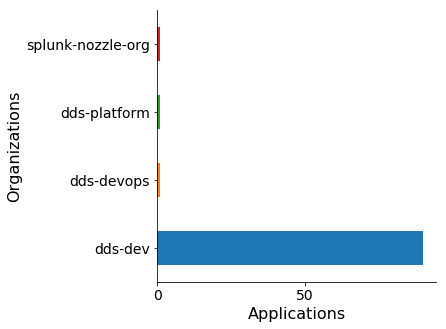

In [222]:
#orgs = apps.groupby("org").size()
orgs = apps[non_system_apps].groupby("org").size()
orgs.plot.barh(figsize=(5,5))
print(orgs)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.ylabel('')
plt.xlabel('Applications', fontsize=16)
plt.ylabel('Organizations', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)


# Apps per Environments (Spaces)

(array([0, 1, 2, 3, 4]), <a list of 5 Text yticklabel objects>)

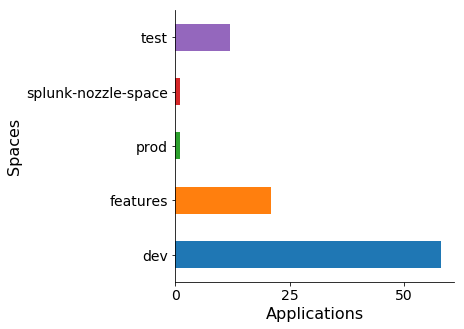

In [184]:
spaces = apps[non_system_apps].groupby("space").size()
spaces.plot.barh(figsize=(5,5))

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.ylabel('')
plt.xlabel('Applications', fontsize=16)
plt.ylabel('Spaces', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

In [10]:
df_apps.head()

from ipywidgets import interactive
 
items = ['All']+sorted(apps['org'].unique().tolist())
 
def view(x=''):
    if x=='All': 
        display(apps)
    else:
        result = apps[apps['org']==x] 
        print ("Total Apps: {}".format(result['instances'].count()))
        display(result)

w = widgets.Select(options=items)
widgets.VBox([widgets.Label('Organizations'), interactive(view, x=w)])






# Application vs Days
## speed
When was an application last updated

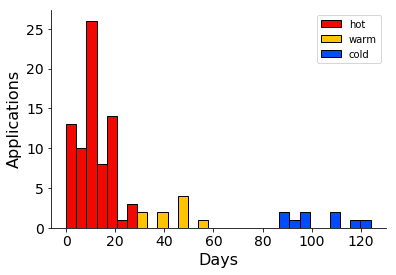

In [139]:
import pylab as plt
from matplotlib.patches import Rectangle

#d = datetime.datetime.strptime('2018-02-07T03:17:13Z', '%Y-%m-%dT%H:%M:%SZ')
def get_days(last_updated):
    deltatime = capture_date - datetime.datetime.strptime(last_updated, '%Y-%m-%dT%H:%M:%SZ')
    return deltatime.days

# df_non_system_apps['days'] = df_non_system_apps['updated'].apply(get_days)
app_days = df_non_system_apps['updated'].apply(get_days)

#app_days.plot.hist(bins=50)
N, bins, patches = plt.hist(app_days, 30, ec='k')

cmap = plt.get_cmap('jet')
hot = cmap(0.9)
warm =cmap(0.7)
cold = cmap(0.2)

for i in range(0,7):
    patches[i].set_facecolor(hot)
for i in range(7,14):
    patches[i].set_facecolor(warm)
for i in range(14,30):
    patches[i].set_facecolor(cold)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [hot,warm, cold]]
labels= ["hot","warm", "cold"]
plt.legend(handles, labels)

plt.xlabel('Days', fontsize=16)
plt.ylabel('Applications', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)



In [146]:
app_days.describe()

count     93.000000
mean      23.118280
std       28.791926
min        0.000000
25%       10.000000
50%       12.000000
75%       20.000000
max      124.000000
Name: updated, dtype: float64

# Buildpack Distribution

In [199]:
pd.DataFrame(df_non_system_apps.groupby("buildpack").size())


,0
buildpack,
binary_buildpack,1
https://github.com/cloudfoundry/buildpack-python.git,2
https://github.com/heroku/heroku-buildpack-python,1
java_buildpack_offline,37
python_buildpack,3
staticfile_buildpack,49


Text(0,0.5,'')

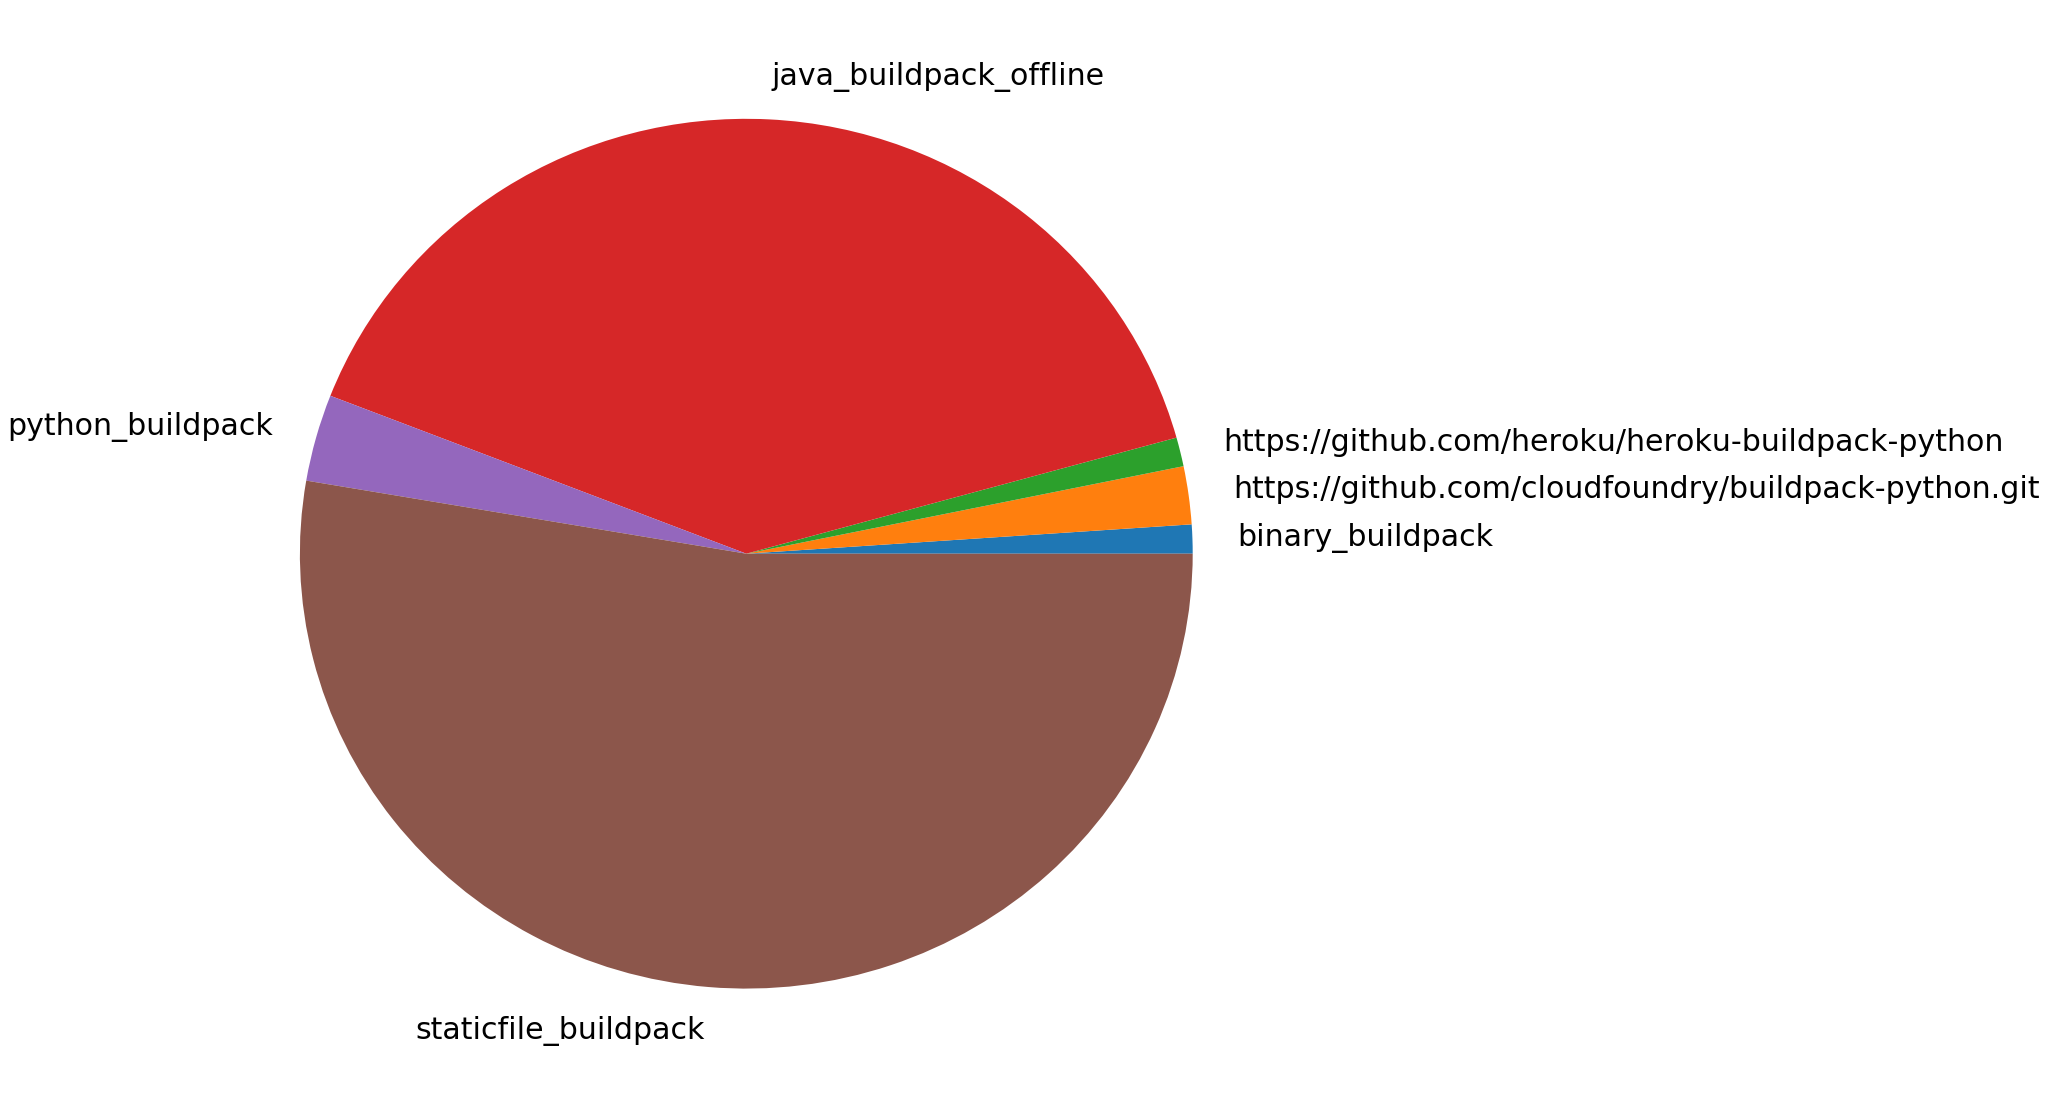

In [191]:
import matplotlib.pyplot as plt
import matplotlib.patches


buildpacks = df_non_system_apps.groupby("buildpack").size()

# buildpacks.plot.pie(figsize=(20,20), title="Buildpack Distribution")
buildpacks.plot.pie(figsize=(20,20))



plt.ylabel('')

# labels = df_apps['buildpack'].unique()

# handles = []
# for i, l in enumerate(labels):
#     handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i)/8.), label=l))
# plt.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

In [13]:
AI_memory = df_apps["memory"].sum()
AI_count = df_apps["instances"].sum()
unique_apps = len(apps['name'].unique())

print("Total Apps is {}".format(unique_apps))
print("Total AIs: {} consuming {} MB RAM".format(AI_count, AI_memory))


Total Apps is 111
Total AIs: 161 consuming 132612 MB RAM


# Services

Text(0,0.5,'')

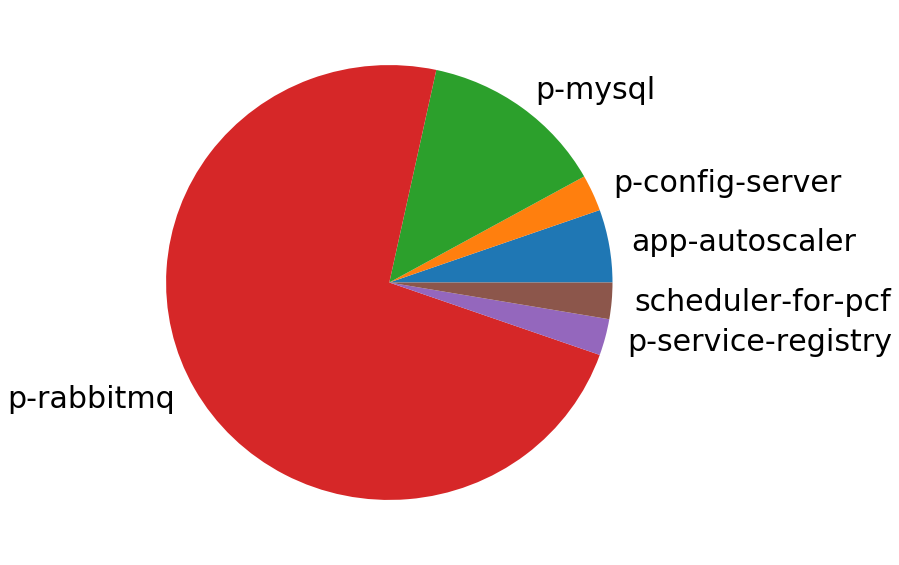

In [217]:

pd.DataFrame(df_service_instances.groupby("service_guid").size())

service_usage = services.groupby('label').size()

service_usage.plot.pie(figsize=(10,10))


plt.ylabel('')

In [219]:
service_usage

label
app-autoscaler         2
p-config-server        1
p-mysql                5
p-rabbitmq            27
p-service-registry     1
scheduler-for-pcf      1
dtype: int64